# Extract features from textual data using BERT and Path signature

In [1]:
import pandas as pd
import torch
import pickle
import re

import nlpsig
from nlpsig.ffn import FeedforwardNeuralNetModel
from nlpsig.focal_loss import FocalLoss
from nlpsig.huggingface_loader import loadHF

/Users/rchan/opt/miniconda3/envs/py38esig/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load dataset

In [2]:
# loadHF: load a dataset from hugging face
data_loader = loadHF(dataset_name="newspop", split_name="train")
data_loader.load_preprocessed_df(default_preprocess="newspop")
dataset_df = data_loader.dataset_df

[INFO] load dataframe, split: train...


Found cached dataset newspop (/Users/rchan/.cache/huggingface/datasets/newspop/default/0.0.0/9904d4082ffd3c0953efa538ff926c43d27da8f37c9b5d6a13f51ab96740474e)
100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 273.23it/s]


[INFO] preprocess...
[INFO] preprocessed dataframe can be accessed: .dataset_df


In [3]:
dataset_df.head()

,content,datetime,label,timeline_id,postid
0,Obama Lays Wreath at Arlington National Cemete...,2015-01-03 00:00:00,1,4,9
1,"Tim Haywood, investment director business-unit...",2015-01-03 00:00:00,2,4,0
2,"Nouriel Roubini, NYU professor and chairman at...",2015-01-02 00:00:00,2,2,8
3,Finland's economy expanded marginally in the t...,2015-01-02 00:12:00,2,3,9
4,Tourism and public spending continued to boost...,2015-01-02 00:00:00,2,2,9


In [4]:
len(dataset_df)

93239

In [5]:
dataset_df = dataset_df[:2000]
dataset_df["label"].value_counts()

0    1131
2     845
1      24
Name: label, dtype: int64

## Model specifics

Nested dictionary for models specifications.

This includes models for encoding text, path signature and etc.

In [26]:
model_specifics = {
    "encoder_args": {
        "col_name_text": "content",
        "model_name": "all-MiniLM-L6-v2",
        "model_args": {
            "batch_size": 64,
            "show_progress_bar": True,
            "output_value": 'sentence_embedding', 
            "convert_to_numpy": True,
            "convert_to_tensor": False,
            "device": None,
            "normalize_embeddings": False
        }
    },
    "dim_reduction": {
        "method": 'umap', #options: ppapca, ppapcappa, umap
        "num_components": 10, # options: any int number between 1 and embedding dimensions
    },
    "embedding":{
        "global_embedding_tp": 'SBERT', #options: SBERT, BERT_cls , BERT_mean, BERT_max
        "post_embedding_tp": 'sentence', #options: sentence, reduced
        "feature_combination_method": 'attention', #options concatenation, attention 
    },
    "time_injection": {
        "history_tp": 'timestamp', #options: timestamp, None
        "post_tp": 'timestamp', #options: timestamp, timediff, None
    },
    "signature": {
        "dimensions": 3, #options: any int number larger than 1
        "method": 'log', # options: log, sig
        "interval": 1/12
    }
}

## Encode text and reduce dimensionality

In [7]:
model_specifics["encoder_args"]

{'col_name_text': 'content',
 'model_name': 'all-MiniLM-L6-v2',
 'model_args': {'batch_size': 64,
  'show_progress_bar': True,
  'output_value': 'sentence_embedding',
  'convert_to_numpy': True,
  'convert_to_tensor': False,
  'device': None,
  'normalize_embeddings': False}}

In [8]:
# initialise the Text Encoder 
text_encoder = nlpsig.TextEncoder(dataset_df,
                                  col_name_text = model_specifics["encoder_args"]["col_name_text"], 
                                  model_name = model_specifics["encoder_args"]["model_name"],
                                  model_args = model_specifics["encoder_args"]["model_args"])

In [9]:
text_encoder.encode_sentence_transformer()

[INFO] number of sentences to encode: 2000


Batches: 100%|████████████████████████████████████████████████████████████████| 32/32 [00:06<00:00,  4.95it/s]


In [10]:
embeddings_sentence = text_encoder.embeddings_sentence

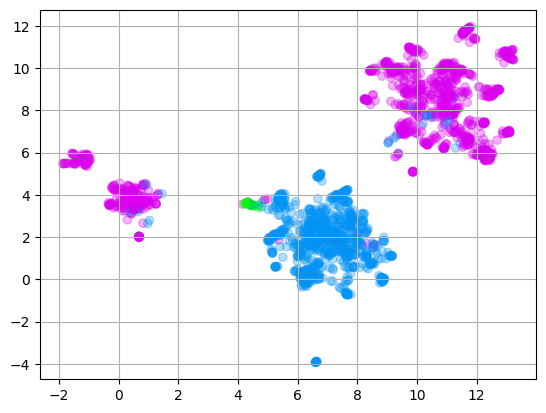

In [21]:
plt_embed = nlpsig.PlotEmbedding(x_data = embeddings_sentence,
                                 y_data = dataset_df["label"].values)

plt_embed.plt_2d(
    embed_args = {
        "method": "umap",
        "dim": 2
    }
)

## Dimensionality reduction

In [12]:
reduction = nlpsig.DimReduce(method = model_specifics["dim_reduction"]['method'], 
                             components = model_specifics["dim_reduction"]['num_components'])
embeddings_reduced = reduction.fit_transform(embeddings_sentence)

In [13]:
print(embeddings_sentence.shape)
print(embeddings_reduced.shape)

(2000, 384)
(2000, 10)


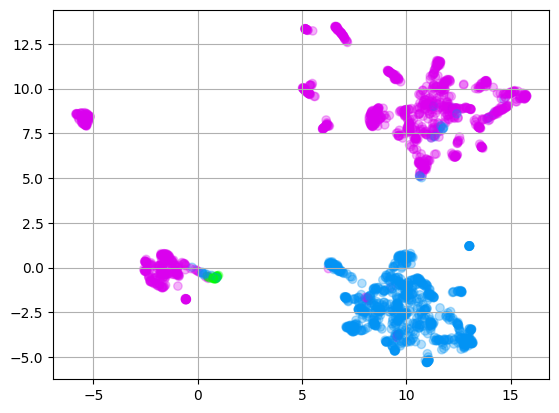

In [22]:
plt_embed = nlpsig.PlotEmbedding(x_data = embeddings_reduced,
                                 y_data = dataset_df["label"].values)

plt_embed.plt_2d(
    embed_args = {
        "method": "umap",
        "dim": 2
    }
)

## Time injection

In [23]:
# concatenate new dataframe 
df = nlpsig.get_modeling_dataframe(dataset_df,
                                   embeddings_sentence,
                                   embeddings_reduced)

# get time features
tf = nlpsig.TimeFeatures()
df = tf.get_time_features(df)

# padding
pad = nlpsig.Padding()
df_padded = pad.pad_timelines(df)
df_padded.shape

(12, 189, 13)

In [123]:
id_counts = df.groupby(['timeline_id'])['timeline_id'].count()

In [126]:
df[["content", "datetime", "label", "postid"]]

,content,datetime,label,postid
0,"Nouriel Roubini, NYU professor and chairman at...",2015-01-01 00:00:00,2,9
1,The Microsoft Band 2 hit the market in late 20...,2015-01-01 00:00:00,0,0
2,It seems that Microsoft is getting ready to pu...,2015-01-01 00:00:00,0,8
3,China's central bank on Monday cut the proport...,2015-01-01 00:00:00,2,1
4,Microsoft is unveiling exactly what apps and ...,2015-01-01 00:00:00,0,8
...,...,...,...,...
1995,That was a strong rebound from August and Sept...,2015-01-06 00:12:00,2,3
1996,Get ready for split-screen productivity. Micro...,2015-01-06 00:12:00,0,7
1997,The likelihood that a bomb caused the crash of...,2015-01-06 00:12:00,2,6
1998,We've heard a lot about the promise of AR over...,2015-01-06 00:12:00,0,4


In [27]:
if (model_specifics["time_injection"]["history_tp"] == 'timestamp'):
    path = torch.from_numpy(df_padded[: , : , 2:].astype(float))
else:
    path = torch.from_numpy(df_padded[: , : , 3:].astype(float))

if (model_specifics["time_injection"]["post_tp"]== 'timestamp'):
    time_feature = torch.tensor((df[['time_encoding']].values - df['time_encoding'].mean()) / df['time_encoding'].std() )
    post_time = True
elif (model_specifics["time_injection"]["post_tp"]== 'timediff'):
    time_feature = torch.tensor( (df[['time_diff']].values - df['time_diff'].mean()) / df['time_diff'].std()  )
    post_time = True  
else: 
    time_feature = None
    post_time = False

if (model_specifics["embedding"]['post_embedding_tp'] == 'sentence'):
    bert_embeddings = torch.tensor(df[[c for c in df.columns if re.match("^e\w*[0-9]", c)]].values)
else:
    bert_embeddings = None

In [28]:
path.shape

torch.Size([12, 189, 11])

In [29]:
#path = path.squeeze()

## Compute signature and create features

In [30]:
path.shape

torch.Size([12, 189, 11])

In [32]:
# calculate paths
dsig = nlpsig.DyadicSignatures(original_size = df.shape[0], 
                        dim = path.shape[2], 
                        sig_dim = model_specifics["signature"]['dimensions'],
                        intervals = model_specifics["signature"]["interval"], 
                        k_history= None, 
                        embedding_tp = model_specifics["embedding"]['post_embedding_tp'],
                        method = model_specifics["embedding"]['feature_combination_method'],
                        history_tp = model_specifics["signature"]['method'], 
                        add_time = post_time)

In [33]:
sig, last_index_dt_all = dsig.compute_signatures(path)
sig_combined = dsig.combine_signatures(sig)

In [34]:
x_data = dsig.create_features(path, sig_combined, last_index_dt_all, bert_embeddings, time_feature)

In [35]:
sig.shape, last_index_dt_all.shape, sig_combined.shape, x_data.shape

(torch.Size([12, 108, 1463]),
 torch.Size([12, 108]),
 torch.Size([12, 108, 1463]),
 torch.Size([2000, 507]))

## Plot embeddings

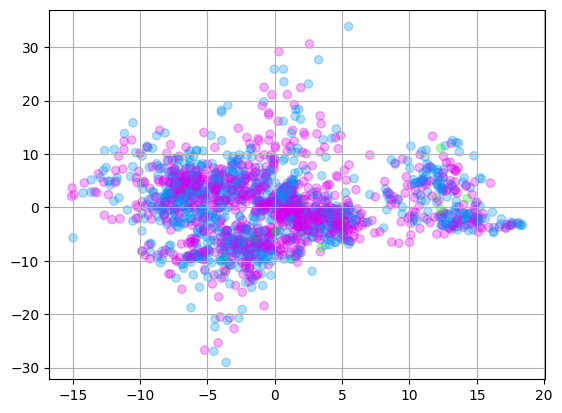

In [39]:
plt_embed = nlpsig.PlotEmbedding(x_data = x_data,
                                 y_data = df["label"].values)
plt_embed.plt_2d(
    embed_args = {
        "method": "pca",
        "dim": 2
    }
)

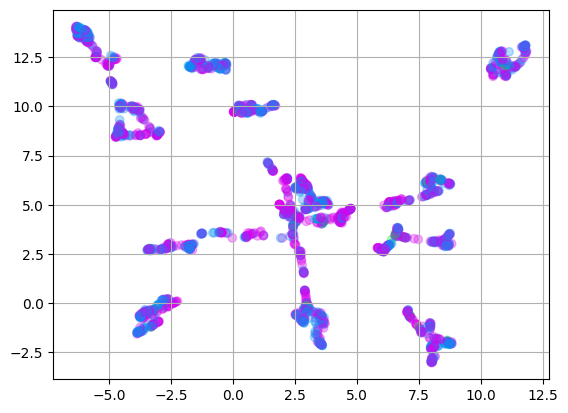

In [40]:
plt_embed.plt_2d(
    embed_args = {
        "method": "umap",
        "dim": 3
    }
)

## Missing: Training classifiers, cross validation, ...

In [49]:
input_dim = x_data.shape[1]
hidden_dim = 200 #200
output_dim = 3
dropout_rate = 0.35 #0.35 #higher dropout than 0.25 and specifically 0.35 is very promising
num_epochs = 100
learning_rate = 0.0003 #0.0003 #empirically optimal lr value: 0.0001
gamma = 2 #3 #empirically optimal gamma value: 3
BATCH_SIZE = 64
NUM_folds = 5
patience = 2
weight_decay_adam = 0.0001

In [50]:
data_folds = nlpsig.GroupFolds(df = df,
                   x_data = x_data,
                   y_data = torch.tensor(df["label"]),
                   groups = df["timeline_id"],
                   n_splits = NUM_folds)

In [51]:
# initial model definitions
model = FeedforwardNeuralNetModel(input_dim,
                                  hidden_dim,
                                  output_dim,
                                  dropout_rate)
criterion = FocalLoss(gamma = gamma)
criterion.set_alpha_from_y(y = torch.tensor(df["label"]))
optimizer = torch.optim.Adam(model.parameters(),
                             lr = learning_rate,
                             weight_decay = weight_decay_adam)

In [52]:
test = nlpsig.KFold_pytorch(data_folds,
                            model = model,
                            criterion = criterion,
                            optimizer = optimizer,
                            num_epochs = 1000)

--------------------------------------------------
Fold: 1 / 5
--------------------------------------------------
Epoch: 1/1000 || Item: 0/1105 || Loss: 0.7464812397956848
--------------------------------------------------
##### Epoch: 1/1000 || Loss: 0.27270254492759705
--------------------------------------------------
Epoch: 0 || Loss: 0.5548193760078994 || Accuracy: 0.5651376247406006 || F1-score: 0.3481087470449173.
Epoch: 2/1000 || Item: 0/1105 || Loss: 0.7605646848678589
Epoch: 1 || Loss: 0.5263337563637883 || Accuracy: 0.5596330165863037 || F1-score: 0.34887422906347404.
Epoch: 3/1000 || Item: 0/1105 || Loss: 0.2542017996311188
Epoch: 2 || Loss: 0.5400266604715906 || Accuracy: 0.5559632778167725 || F1-score: 0.33300845452336186.
Epoch: 4/1000 || Item: 0/1105 || Loss: 0.3440786600112915
Epoch: 3 || Loss: 0.6558150320703519 || Accuracy: 0.5559632778167725 || F1-score: 0.2973472138575813.
Epoch: 5/1000 || Item: 0/1105 || Loss: 0.8982164263725281
Epoch: 4 || Loss: 0.770405237308506

Epoch: 11 || Loss: 0.5584975324137444 || Accuracy: 0.5159362554550171 || F1-score: 0.3268039478174134.
Epoch: 13/1000 || Item: 0/1017 || Loss: 0.057469893246889114
Epoch: 12 || Loss: 0.6240227255622361 || Accuracy: 0.5697211027145386 || F1-score: 0.2587173579109063.
Epoch: 14/1000 || Item: 0/1017 || Loss: 0.05516263470053673
Epoch: 13 || Loss: 0.7605951619978042 || Accuracy: 0.5438246726989746 || F1-score: 0.23821989528795814.
Epoch: 15/1000 || Item: 0/1017 || Loss: 0.19158576428890228
Epoch: 14 || Loss: 0.6754063337803199 || Accuracy: 0.5498008131980896 || F1-score: 0.30493904978860026.
Epoch: 16/1000 || Item: 0/1017 || Loss: 0.19732291996479034
Epoch: 15 || Loss: 0.9428181017213028 || Accuracy: 0.5697211027145386 || F1-score: 0.3471875668353889.
Epoch: 17/1000 || Item: 0/1017 || Loss: 0.16691114008426666
Epoch: 16 || Loss: 1.0394949779565688 || Accuracy: 0.5737051963806152 || F1-score: 0.29929293087187825.
Epoch: 18/1000 || Item: 0/1017 || Loss: 0.061636585742235184
Epoch: 17 || Loss

Epoch: 13 || Loss: 0.8655836644017494 || Accuracy: 0.5711422562599182 || F1-score: 0.34538309710723497.
Epoch: 15/1000 || Item: 0/1013 || Loss: 0.2237769365310669
Epoch: 14 || Loss: 1.578892137004304 || Accuracy: 0.49298596382141113 || F1-score: 0.24785953177257528.
Epoch: 16/1000 || Item: 0/1013 || Loss: 0.7179519534111023
Epoch: 15 || Loss: 1.0335237222265417 || Accuracy: 0.5450901985168457 || F1-score: 0.29751758907708403.
Epoch: 17/1000 || Item: 0/1013 || Loss: 0.17674565315246582
Epoch: 16 || Loss: 1.4774455348824265 || Accuracy: 0.48697394132614136 || F1-score: 0.30418213107473674.
Epoch: 18/1000 || Item: 0/1013 || Loss: 0.5163695812225342
Epoch: 17 || Loss: 1.380232418162897 || Accuracy: 0.5150300860404968 || F1-score: 0.2919437482289254.
Epoch: 19/1000 || Item: 0/1013 || Loss: 0.30370786786079407
Epoch: 18 || Loss: 1.8480396905504586 || Accuracy: 0.5030060410499573 || F1-score: 0.24374984407729539.
Epoch: 20/1000 || Item: 0/1013 || Loss: 0.15522342920303345
Epoch: 19 || Loss: 1

In [53]:
test

,accuracy,f1_score
0,0.542857,0.245527
1,0.556196,0.307404
2,0.559252,0.291906
3,0.449102,0.273333
4,0.551230,0.280386
